In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz, butter, firls, remez, firwin, firwin2, group_delay, fftconvolve
from scipy.fftpack import fft, ifft, fftshift
from scipy.special import sinc

import scipy
import scipy.signal as sig
from scipy.signal import convolve as sig_convolve

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


___
### Окно Хемминга

$$ w(n) = 0.53836 - 0.46164 \cdot cos(\frac{2\pi n}{N-1}) \tag{7.7}$$

Максимальный уровень боковых лепестков: **-42 дБ**.

Python: `signal.hamming(M)`

Методы `firwin` и `firwin2`  возвращают коэффициенты КИХ фильтра. 

**Метод firwin**

 - `numtaps` - порядок фильтра,
 - `cutoff` - частота среза относительно частоты дискретизации `fs`.
 - `width` - если задано значение, то показывает ширину перехода от полосы пропускания до полосы подавления. 
 - `window` - оконная функция. Применяется в совокупности с методом `get_window` или напрямую задается название окна.
 - `fs` - частота дискретизации или частота Найквиста. Если значение не задано, по умолчанию равно единице. 

**Метод firwin2**

 - `numtaps` - порядок фильтра,
 - `freq` - монотонная неубывающая последовательность частот. Все элементы должны быть неотрицательными и меньше или равными частоте Найквиста, заданной параметром `fs`.
 - `gain` - последовательность амплитуд, содержащая требуемое усиление и ослабление на заданных значениях частот из `freq`.
 - `window` - оконная функция. Применяется в совокупности с методом `get_window` или напрямую задается название окна.
 - `fs` - частота дискретизации или частота Найквиста. Если значение не задано, по умолчанию равно единице. 

In [2]:
def plt_sel(s, *args, **kwargs):
    if s == 0:
        return plt.plot(*args)
    if s == 1:
        return plt.stem(*args, **kwargs)
    if s == 2:
        return plt.step(*args)

In [51]:
# частота синусоидального сигнала
f = 100
# частота дискретизации
fs = 60
# частота найквиста
nyq_rate = f * 2
# относительная круговая частота
w = 2 * np.pi * f / fs
# стартовое смещение
fi = np.pi / 2

In [52]:
t_min = 0
t_max = 3

t_len = fs

# time vector
t = np.linspace(0, 3, t_len, endpoint=True)

In [53]:
# синусоидальный сигнал
x = np.sin(w * t + fi)

# входные данные
in_vals = np.zeros(t_len)
for ind, x_val in enumerate(x):
    in_vals[ind]=x_val

C:\Users\iverendeev\AppData\Local\Temp\ipykernel_20000\2346563309.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  return plt.stem(*args, **kwargs)


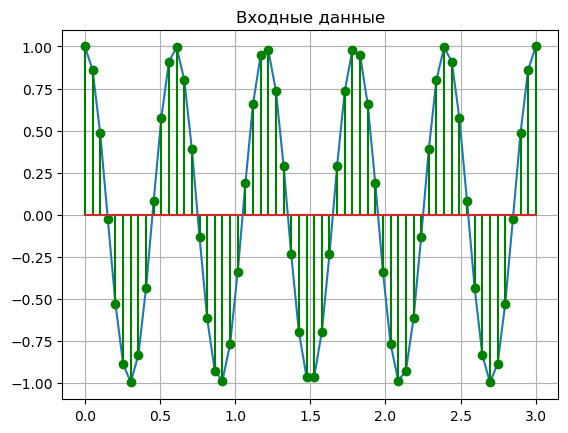

In [54]:
plt_sel(0
      , t
      , in_vals
      , use_line_collection=True
      , color="g")
plt_sel(1
      , t
      , in_vals
      , use_line_collection=True
      , linefmt="g")
plt.title("Входные данные")
plt.grid()
plt.show()

In [55]:
L = 8
new_n = L * (t_len - 1) + 1
new_fs = L * fs

In [56]:
new_t = np.interp(np.arange(new_n), np.arange(new_n, step=L), t)

new_x = np.empty(new_n)
new_x.fill(0)

for i, _ in enumerate(x):
    new_x[i*L] = x[i]

C:\Users\iverendeev\AppData\Local\Temp\ipykernel_20000\2346563309.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  return plt.stem(*args, **kwargs)


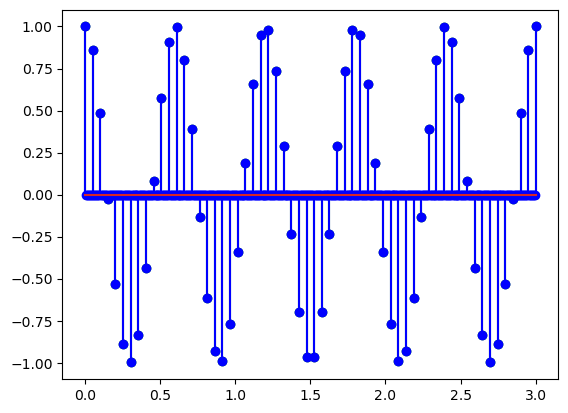

In [57]:
plt_sel(1
      , t
      , x
      , use_line_collection=True
      , linefmt="g")

plt_sel(1
      , new_t
      , new_x
      , use_line_collection=True
      , linefmt="b")
plt.show()

Check freqz:

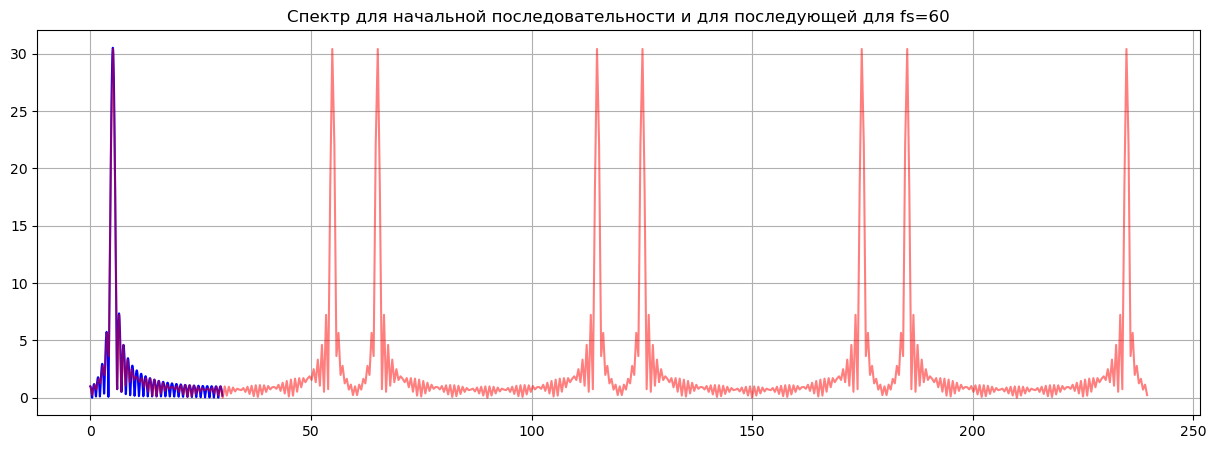

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

wx, hx = sig.freqz(x, fs=fs)
# plt.plot(wx, hx, 'b')
plt.plot(wx, np.absolute(hx), 'b')

wx_new, hx_new = sig.freqz(new_x, fs=new_fs)
# plt.plot(wx_new, hx_new, 'r', alpha=0.5)
plt.plot(wx_new, np.absolute(hx_new), 'r', alpha=0.5)

plt.title(f"Спектр для начальной последовательности и для последующей для fs={fs}")
plt.grid()
plt.show()

#### Work with filters
Docs for [scipy.signal](https://github.com/scipy/scipy/blob/v1.11.2/scipy/signal/_fir_filter_design.py#L465)

In [59]:
f_cutoff = fs / 2
nyq = 0.5 * new_fs
cutoff = np.atleast_1d(f_cutoff) / float(nyq)

filter_n = 51

fac = np.linspace(-np.pi, np.pi, filter_n)

In [60]:
alpha = 0.5 * (filter_n - 1)
m = np.arange(0, filter_n) - alpha

ideal_filter = firwin(filter_n, cutoff = fs / 2, window = "hamming", fs=new_fs, scale=False)

y = np.pi * np.where(m == 0, 1.0e-20, m)
my_filter = np.sin(cutoff * y) / y

# windows - hamming
# window = sig.windows.hamming(filter_n)
window = 0.54 * np.cos(0.54 * fac) + 0.46 * np.cos(0.46 * fac)

my_filter = my_filter * window

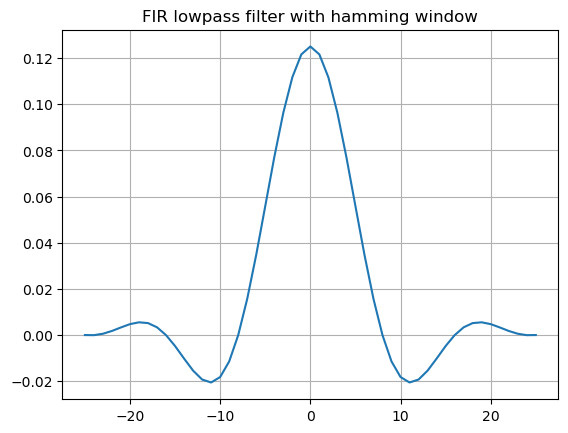

In [61]:
plt.plot(m, my_filter)
plt.title('FIR lowpass filter with hamming window')
plt.grid()
plt.show()

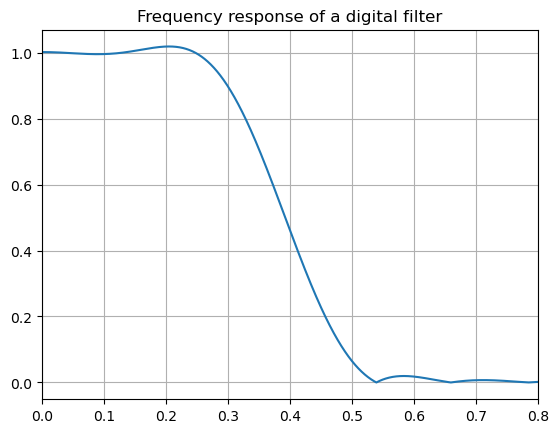

In [66]:
w, h = freqz(my_filter, worN=8000)
plt.plot(w, np.absolute(h))
plt.title("Frequency response of a digital filter")
plt.xlim([0, 0.8])
plt.grid()
plt.show()

In [63]:
results = np.convolve(new_x, L*my_filter, mode='same')

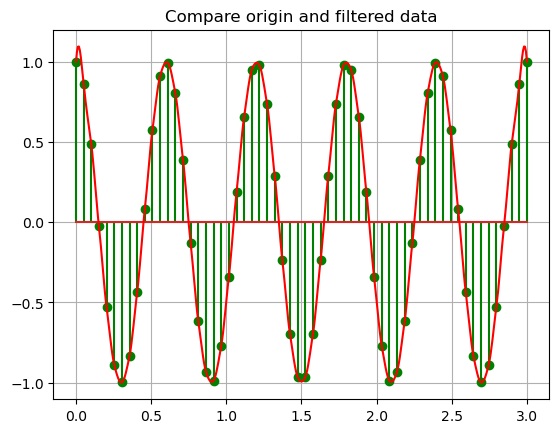

In [64]:
plt.stem(t, x, linefmt='g', label='origin')
plt.plot(new_t, results, color='r', label='filtered')
plt.title("Compare origin and filtered data")
plt.grid()
plt.show()

In [65]:
for i, j in zip(new_x, results):
    print(i, "      ", j)

1.0        1.0
0.0        1.062422403913055
0.0        1.093398979885123
0.0        1.094949329117732
0.0        1.0716673632892966
0.0        1.029889791766995
0.0        0.9766722266350656
0.0        0.9185294341976563
0.8615540813938061        0.8615540813938061
0.0        0.8061044368267803
0.0        0.7538405166130846
0.0        0.7051941758687668
0.0        0.6596568917370074
0.0        0.6161348105327131
0.0        0.5732906366389239
0.0        0.5294622395767621
0.4845508703326499        0.4845508703326499
0.0        0.4322578335243171
0.0        0.3722953626393658
0.0        0.30591602151000324
0.0        0.23559672040973412
0.0        0.16447955820856847
0.0        0.09568061970173822
0.0        0.03121138622964785
-0.026620521437774856        -0.026620521437774856
0.0        -0.08429670100592736
0.0        -0.14831763051050129
0.0        -0.21640378498353663
0.0        -0.28658754383241075
0.0        -0.35580075838496467
0.0        -0.42094363559902187
0.0        -0.4798919

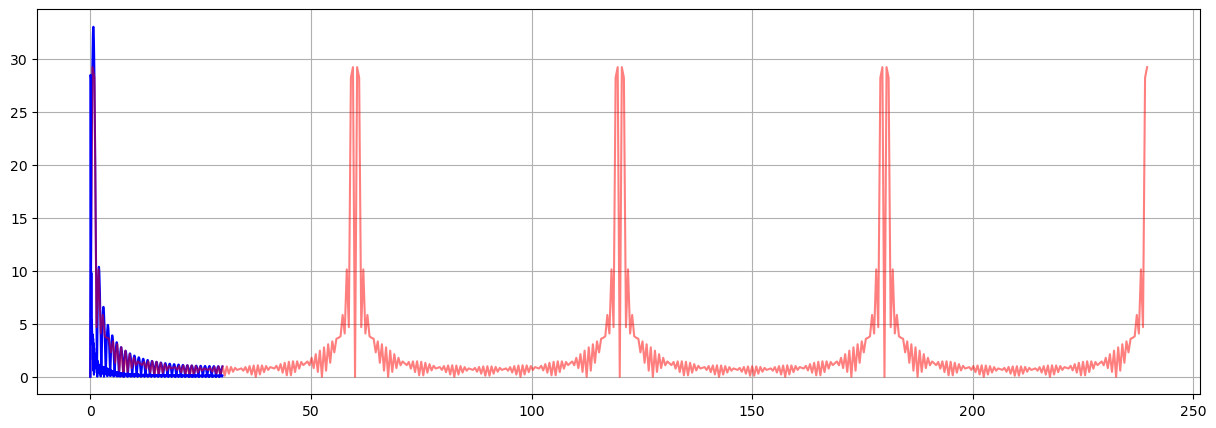

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

wx, hx = sig.freqz(x, fs=fs)
# plt.plot(wx, hx, 'b')
plt.plot(wx, np.absolute(hx), 'b')

wx_new, hx_new = sig.freqz(new_x, fs=new_fs)
# plt.plot(wx_new, hx_new, 'r', alpha=0.5)
plt.plot(wx_new, np.absolute(hx_new), 'r', alpha=0.5)

wx, hx = sig.freqz(results/L, fs=fs)
# plt.plot(wx, hx, 'b')
plt.plot(wx, np.absolute(hx), 'b')
plt.grid()
plt.show()